## A simple 2D CNN for MNIST digit recognition
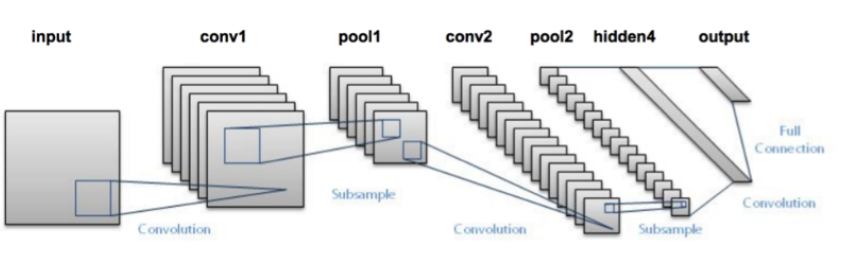

# 1 Preparing the data

In [26]:
import keras
from keras.datasets import mnist
#load mnist dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data() 

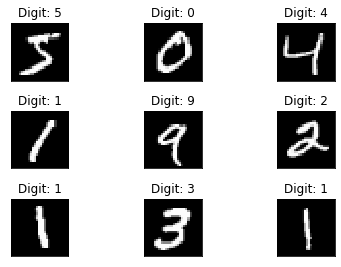

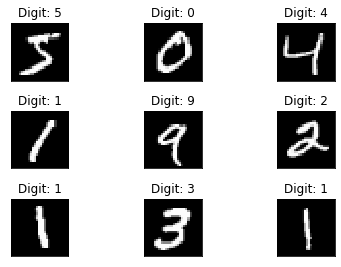

In [27]:
#Visualization of the first 9 data from training to get a better idea about the purpose of the deep learning model.
import matplotlib.pyplot as plt
fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(X_train[i], cmap='gray', interpolation='none')
  plt.title("Digit: {}".format(y_train[i]))
  plt.xticks([])
  plt.yticks([])
fig

## reshaping
### this assumes our data format for 3D data, "channels_last" assumes (conv_dim1, conv_dim2, conv_dim3, channels) while  "channels_first" assumes (channels, conv_dim1, conv_dim2, conv_dim3).

In [28]:
#input image size 28*28
img_rows , img_cols = 28, 28

from keras import backend as k

if k.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
#more reshaping
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


# 2 Building and compiling of the model

# CNN ARCHITECTURE
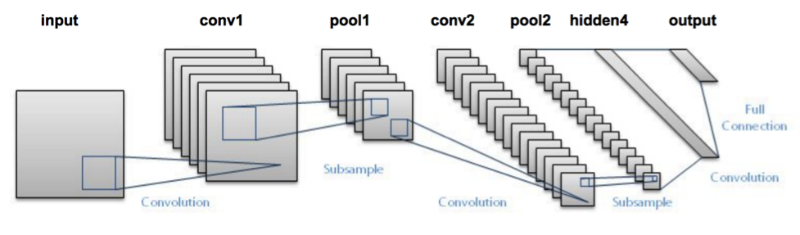

In [29]:
#set number of categories
num_category = 10
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_category)
y_test = keras.utils.to_categorical(y_test, num_category)
y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [30]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras import backend as k

#model building
model = Sequential()
#convolutional layer with rectified linear unit activation
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
#32 convolution filters used each of size 3x3
#again
model.add(Conv2D(64, (3, 3), activation='relu'))
#64 convolution filters used each of size 3x3
#choose the best features via pooling
model.add(MaxPooling2D(pool_size=(2, 2)))
#randomly turn neurons on and off to improve convergence
model.add(Dropout(0.25))
#flatten since too many dimensions, we only want a classification output
model.add(Flatten())
#fully connected to get all relevant data
model.add(Dense(128, activation='relu'))
#one more dropout for convergence' sake :) 
model.add(Dropout(0.5))
#output a softmax to squash the matrix into output probabilities
model.add(Dense(num_category, activation='softmax'))
#Adaptive learning rate (adaDelta) is a popular form of gradient descent rivaled only by adam and adagrad
#categorical ce since we have multiple classes (10) 
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [31]:
batch_size = 128
num_epoch = 10
#model training
model_log = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=num_epoch,
          verbose=1,
          validation_data=(X_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 73s 1ms/step - loss: 0.2714 - accuracy: 0.9160 - val_loss: 0.0563 - val_accuracy: 0.9812
Epoch 2/10
60000/60000 [==============================] - 71s 1ms/step - loss: 0.0878 - accuracy: 0.9738 - val_loss: 0.0414 - val_accuracy: 0.9858
Epoch 3/10
60000/60000 [==============================] - 92s 2ms/step - loss: 0.0662 - accuracy: 0.9794 - val_loss: 0.0334 - val_accuracy: 0.9890
Epoch 4/10
60000/60000 [==============================] - 111s 2ms/step - loss: 0.0552 - accuracy: 0.9833 - val_loss: 0.0359 - val_accuracy: 0.9879
Epoch 5/10
60000/60000 [==============================] - 112s 2ms/step - loss: 0.0460 - accuracy: 0.9862 - val_loss: 0.0289 - val_accuracy: 0.9910
Epoch 6/10
60000/60000 [==============================] - 112s 2ms/step - loss: 0.0436 - accuracy: 0.9865 - val_loss: 0.0266 - val_accuracy: 0.9909
Epoch 7/10
60000/60000 [==============================] - 111s 2m

In [32]:
#how well did it do? 
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.027548574298199856
Test accuracy: 0.9908999800682068


# 3 Save the model

In [33]:
# serialize model to JSON
model_digit_json = model.to_json()
with open("model_digit.json", "w") as json_file:
    json_file.write(model_digit_json)
# serialize weights to HDF5
model.save_weights("model_digit.h5")
print("Saved model to disk")

Saved model to disk


# 4 Prediction

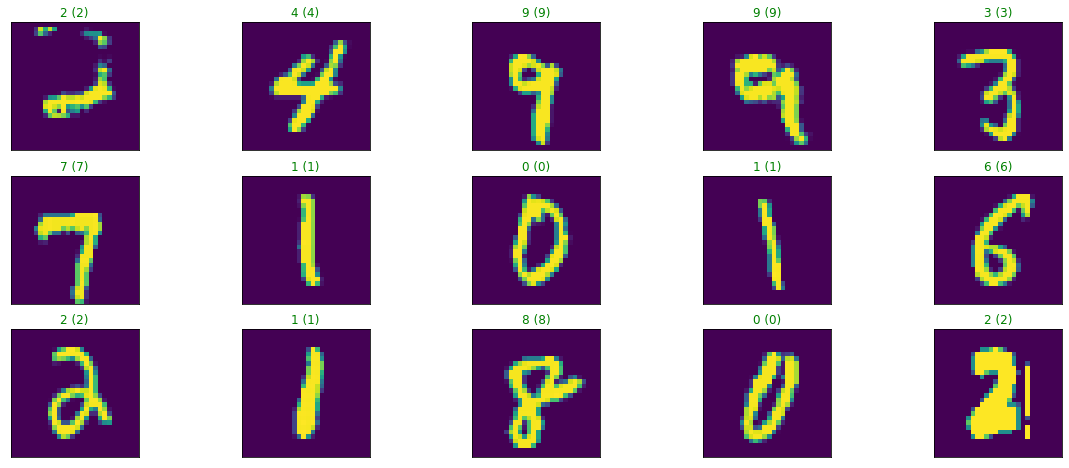

In [34]:
import numpy as np
y_hat = model.predict(X_test)
# Plot a random sample of 10 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(X_test.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(X_test[index]))
    predict_digit = np.argmax(y_hat[index])
    true_digit = np.argmax(y_test[index])
    # Set the title for each image
    ax.set_title("{} ({})".format(predict_digit,true_digit),
                                color=("green" if predict_digit == true_digit else "red"))